In [32]:
from enum import Enum
import random 
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [33]:

class CellType(Enum):
    PROLIFERATING = [28/255, 241/255, 93/255]
    COMPLEX = [26/255, 69/255, 245/255]
    DEAD = [245/255, 72/255, 27/255]
    NECROTIC = [130/255, 130/255, 130/255]
    
    
    
class Cell:
    
    def __init__(self, x, y, cellType, nNeighbors):
        self.x = x
        self.y = y
        self.cellType = cellType
        #Tiempo de muerte según el artículo
        self.life = 20 + nNeighbors + poisson.rvs(mu = 1, size = 1)
    
    def __eq__(self, other):
        self.x == other.x and self.y == other.y
        
    def dayInTheLife(self):
        self.life = self.life - 1
        #Si ha pasado su tiempo de vida se vuelve necrotica
        if(self.life == 0):
            self.cellType = CellType.NECROTIC
    

class Tissue:
    
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.occupiedPositions = np.zeros((self.height, self.width))
        self.necroticPositions = np.zeros((self.height, self.width))
        self.initializeECM()
        self.cells = []
        self.colorNecrotic = [176/255, 176/255, 176/255]
        #Tasa de consumo de la matriz extracelular
        self.ec = 0.1
        self.et = 0.05
        #Otros parámetros
        self.rProlif = 0.85
        self.rBinding = 0.1
        self.rEscape = 0.5
        self.rLysis = 0.35
        self.rDecay = 0.35
        self.K = 1000
        self.inmunoThreshold = 100
        
        
    def initializeECM(self):
        self.extraCellularMatrix = np.zeros((self.height, self.width))
        for i in range(0, self.height):
            for j in range(0,self.width):
                #La ECM inicia con valores de [0.8,1.2]
                self.extraCellularMatrix[i,j] = 0.8 + random.random()*(1.2 - 0.8)
    
    
    def countNeighbors(self, x, y):        
        sumNeighbors = 0
        for i in range(-1,2):
            for j in range(-1,2):
                if(i != 0 or j!= 0):
                    sumNeighbors = sumNeighbors + self.occupiedPositions[(y + j)%self.width, (x + i)%self.height]
        return sumNeighbors
    
    def getPositionsToInfest(self, x, y):
        positions = [];
        for i in range(-1,2):
            for j in range(-1, 2):
                if(i != 0 or j!= 0):
                    row = (y + i)%self.width
                    col = (x + j)%self.height
                    if(self.occupiedPositions[row, col]  == 0 and self.necroticPositions[row, col] == 0 and self.extraCellularMatrix[row, col] < self.et):
                        positions.append([row, col])
        
        return positions
    
    def updateECM(self):
        for i in range(0,self.height):
            for j in range(0,self.width):
                deltaECM = -self.ec*self.countNeighbors(j, i)*self.extraCellularMatrix[i,j]
                self.extraCellularMatrix[i,j] = self.extraCellularMatrix[i,j] + deltaECM
                
    def addComplexCell(self, x, y):
        nNeighbors = self.countNeighbors(x,y)
        self.cells.append(Cell(x,y,CellType.COMPLEX, nNeighbors))
        self.occupiedPositions[y,x] = 1
                
    def initializeInmuno(self):
        
        print("Initialiazing Inmunoterapy")
        
        centerX = int(self.width/2)
        centerY = int(self.width/2)
        self.rProlif =  self.rProlif-0.02
        self.rBinding = self.rBinding + 0.01
        self.rEscape = self.rEscape - 0.01
        self.rLysis =  self.rLysis + 0.01
        self.rDecay = self.rDecay + 0.01
        
        nNeighbors = self.countNeighbors(centerX,centerY)
        for i in range(0,10):
            
            self.addComplexCell(centerX + i,centerY)
            self.addComplexCell(centerX - i, centerY)
            self.addComplexCell(centerX - i, centerY-i)
            self.addComplexCell(centerX - i, centerY+i)
            self.addComplexCell(centerX + i, centerY-i)
            self.addComplexCell(centerX + i, centerY+i)
            self.addComplexCell(centerX, centerY + i)
            self.addComplexCell(centerX, centerY - i)
            
    def initializeInmuno2(self):
        
        print("Initialiazing Inmunoterapy second session")
        
        centerX = int(self.width/2)
        centerY = int(self.width/2)
        self.rProlif =  self.rProlif-0.02
        self.rBinding = self.rBinding + 0.01
        self.rEscape = self.rEscape - 0.01
        self.rLysis =  self.rLysis + 0.01
        self.rDecay = self.rDecay + 0.01
        
        nNeighbors = self.countNeighbors(centerX,centerY)
        for i in range(0,5):
            
            self.addComplexCell(centerX + i,centerY)
            self.addComplexCell(centerX - i, centerY)
            self.addComplexCell(centerX - i, centerY-i)
            self.addComplexCell(centerX - i, centerY+i)
            self.addComplexCell(centerX + i, centerY-i)
            self.addComplexCell(centerX + i, centerY+i)
            self.addComplexCell(centerX, centerY + i)
            self.addComplexCell(centerX, centerY - i)

        
        
    def updateCells(self):
        cellsToDelete = []
        indsList = list(range(0,len(self.cells)))
        random.shuffle(indsList)
        for i in indsList:
            cell = self.cells[i]
            r = random.random()
            #Proliferadoras
            if(cell.cellType == CellType.PROLIFERATING):
                if(r <= self.rProlifPrime):
                    normalCells = self.getPositionsToInfest(cell.x, cell.y)
                    #print(len(normalCells))
                    if(len(normalCells)>0):
                        normalCell = random.choice(normalCells)
                        self.addProliferatingCell(normalCell[1], normalCell[0])
                else:
                    if(r <= 1 - self.rBinding):
                        self.cells[i].cellType = CellType.COMPLEX
            #Complejas
            elif(cell.cellType == CellType.COMPLEX):
                if(r <= self.rEscape):
                    self.cells[i].cellType = CellType.PROLIFERATING
                elif(r >= 1 - self.rLysis):
                    self.cells[i].cellType = CellType.DEAD
                    
            elif(cell.cellType == CellType.DEAD):
                if(r < self.rDecay):
                    cellsToDelete.append(cell)
                    
            self.cells[i].dayInTheLife()
            if(self.cells[i].cellType == CellType.NECROTIC):
                self.necroticPositions[cell.y, cell.x] = 1
                cellsToDelete.append(cell)
        
        for i in range(0,len(cellsToDelete)):
            if(cellsToDelete[i] in self.cells):
                self.removeCell(cellsToDelete[i])
    
    
    def getCellCounts(self):
        
        proliferatingCells = 0
        complexCells = 0
        for i in range(0,len(self.cells)):
            cell = self.cells[i]
            if(cell.cellType == CellType.PROLIFERATING):
                proliferatingCells = proliferatingCells + 1
            elif(cell.cellType == CellType.COMPLEX):
                complexCells = complexCells + 1
                
        return [proliferatingCells, complexCells, len(self.cells)]
    
    def plotEvolution(self):
        n = np.size(self.cellCountSeries, 0)
        plt.figure(figsize = (10,7))
        plt.plot(self.cellCountSeries[:,0], color = CellType.PROLIFERATING.value, label = "Proliferadora", linewidth = 2)
        plt.plot(self.cellCountSeries[:,1], color = CellType.COMPLEX.value, label = "Compleja", linewidth = 2)
        plt.plot(self.cellCountSeries[:, 2], color = "#ff9a26", label = "Células", linewidth = 2)
        plt.xlabel("Paso")
        plt.ylabel("N.Células")
        plt.legend()
        
        
    
    
    def evolveTissue(self, nSteps):
        self.cellCountSeries = np.zeros((nSteps+1, 3)) 
        counts = self.getCellCounts()
        self.cellCountSeries[0,:] = counts
        for i in range(1, nSteps+1):
            self.rProlifPrime = self.rProlif*(1 - counts[0]/self.K)
            print(i)
            
            self.updateECM()
            self.updateCells()
            
            if (i == 200 ):
                for j in range(0,10):
                    self.initializeInmuno()
            if (i == 400):
                for j in range(0,10):
                    self.initializeInmuno2()
                
            counts = self.getCellCounts()
            self.cellCountSeries[i,:] = counts
            
            
                
            
        
            
     

    def addProliferatingCell(self, x, y):
        
        nNeighbors = self.countNeighbors(x,y)
        self.cells.append(Cell(x,y,CellType.PROLIFERATING, nNeighbors))
        self.occupiedPositions[y,x] = 1
        
   
        
        
      
    def getPicture(self):
        picture = np.zeros((self.height, self.width, 3))
        for i in range(0, len(self.cells)):
            picture[self.cells[i].y, self.cells[i].x,:] = self.cells[i].cellType.value
            
        for i in range(0, self.height):
            for j in range(0, self.width):
                if(self.necroticPositions[i,j] == 1):
                    picture[i,j,:] = self.colorNecrotic
        
        return picture
            
                          
    def removeCell(self, cell):
        self.cells.remove(cell)
        self.occupiedPositions[cell.y, cell.x] = 0
                              
        
    

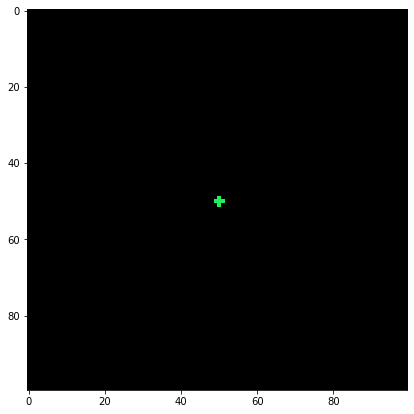

In [34]:
width = 100
height = 100

centerX = int(width/2)
centerY = int(width/2)


tissue = Tissue(width, height)


#Inicializamos el tejido
tissue.addProliferatingCell(centerX, centerY)
tissue.addProliferatingCell(centerX + 1,centerY)
tissue.addProliferatingCell(centerX - 1, centerY)
tissue.addProliferatingCell(centerX, centerY + 1)
tissue.addProliferatingCell(centerX, centerY - 1)





plt.figure(figsize = (7,7))
plt.imshow(tissue.getPicture())

In [35]:
tissue.evolveTissue(500)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
Initialiazing Inmunoterapy
Initialiazing Inmunoterapy
Initialiazing Inmunoterapy
Initialiazing Inmunoterapy
Initialiazing Inmunoterapy
Initialiazing Inmunoterapy
Initialiazing Inmunoterapy
Initialiazing Inmunoterapy
Initialiazing Inmunoterapy
Initialiazing Inmunoterapy
201
202
203
204
205
206
207
208
209
21

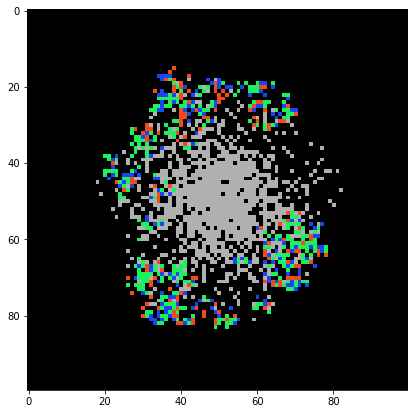

In [36]:
plt.figure(figsize = (7,7))
plt.imshow(tissue.getPicture())

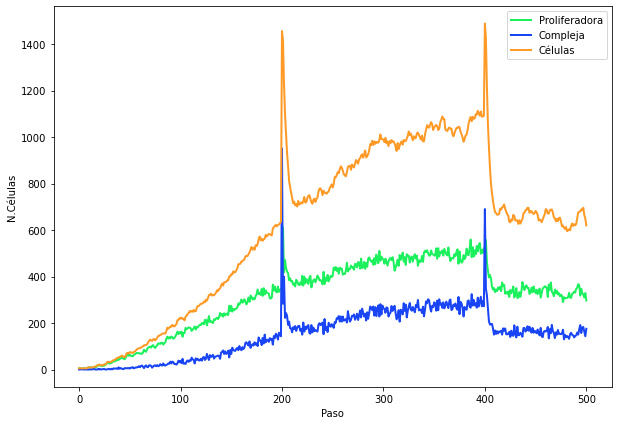

In [37]:
tissue.plotEvolution()

In [25]:
0.8 + random.random()*(1.2 - 0.8)

0.9693999823118055

In [29]:
extraCellularMatrix = np.zeros((10, 10)) 
for i in range(0, 10):
    for j in range(0,10):
    #La ECM inicia con valores de [0.8,1.2]
        extraCellularMatrix[i,j] = 0.8 + random.random()*(1.2 - 0.8)

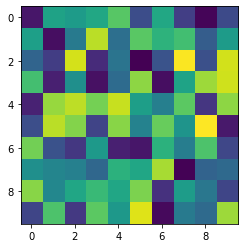

In [31]:
plt.imshow(extraCellularMatrix)